# Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

# Import Data

In [ ]:
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/67349 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteW6KH7W/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/872 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteW6KH7W/glue-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/1821 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteW6KH7W/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [ ]:
train, validation= dataset["train"], dataset["validation"]

In [ ]:
train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [ ]:
#print some of the entries
for example in train.take(5):
  review, label= example["sentence"], example["label"]
  print("review: ", review)
  print("label: ", label.numpy())

review:  tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
label:  0
review:  tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
label:  0
review:  tf.Tensor(b'company once again dazzle and delight us ', shape=(), dtype=string)
label:  1
review:  tf.Tensor(b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke ", shape=(), dtype=string)
label:  1
review:  tf.Tensor(b', this cross-cultural soap opera is painfully formulaic and stilted . ', shape=(), dtype=string)
label:  0


In [ ]:
#get the sentences and labels
training_sentences= []
training_labels= []
validation_sentences= []
validation_labels= []

# The dataset has 67,000 training entries, but that's a lot to process here!
#take 20000 sentences
for item in train.take(20000):
  sentence, label= item["sentence"], item["label"]
  training_sentences.append(str(sentence.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_sentences))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_sentences[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in validation.take(-1):
  review, label = item["sentence"], item["label"]
  validation_sentences.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_sentences))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_sentences[i])
  print (validation_labels[i])


Number of training reviews is:  20000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


# Tokenize the words and sequence the sentences

In [ ]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Pad the sequences

In [ ]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Create the model using an Embedding

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 64017 (250.07 KB)
Trainable params: 64017 (250.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))


Epoch 1/20
625/625 [==============================] - 28s 37ms/step - loss: 0.6801 - accuracy: 0.5649 - val_loss: 0.6772 - val_accuracy: 0.5665
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 0.6507 - accuracy: 0.6211 - val_loss: 0.6250 - val_accuracy: 0.6800
Epoch 3/20
625/625 [==============================] - 3s 4ms/step - loss: 0.5979 - accuracy: 0.6926 - val_loss: 0.5628 - val_accuracy: 0.7362
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 0.5414 - accuracy: 0.7499 - val_loss: 0.5142 - val_accuracy: 0.7534
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 0.4929 - accuracy: 0.7854 - val_loss: 0.4907 - val_accuracy: 0.7890
Epoch 6/20
625/625 [==============================] - 3s 4ms/step - loss: 0.4542 - accuracy: 0.8043 - val_loss: 0.4706 - val_accuracy: 0.7810
Epoch 7/20
625/625 [==============================] - 3s 4ms/step - loss: 0.4230 - accuracy: 0.8208 - val_loss: 0.4648 - val_accuracy: 0.7833
Epoc

# Plot the accurracy and loss

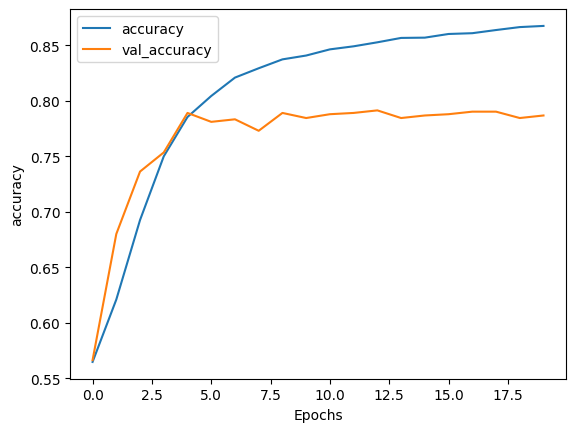

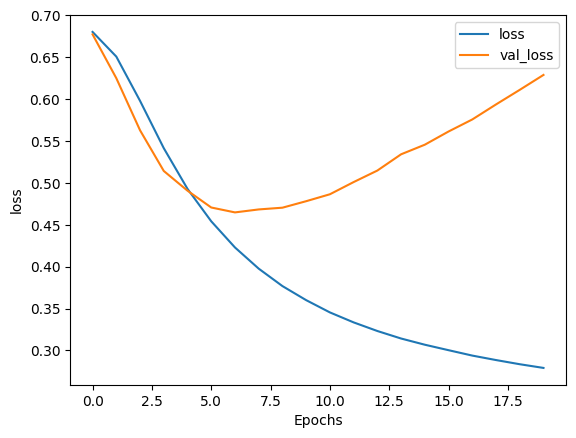

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Write a function to predict the sentiment of reviews

In [ ]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [ ]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_length)
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


1/1 [==============================] - 0s 130ms/step
I loved this movie
[0.5901823]


that was the worst movie I've ever seen
[0.01305546]


too much violence even for a Bond film
[0.0115256]


a captivating recounting of a cherished myth
[0.7488748]




# Define a function to train and show the results

In [ ]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

# CNN Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d (Conv1D)             (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65313 (255.13 KB)
Trainable params: 65313 (255.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 26s 32ms/step - loss: 0.6892

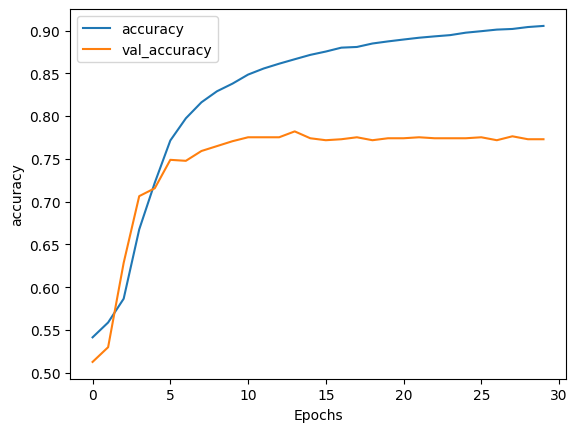

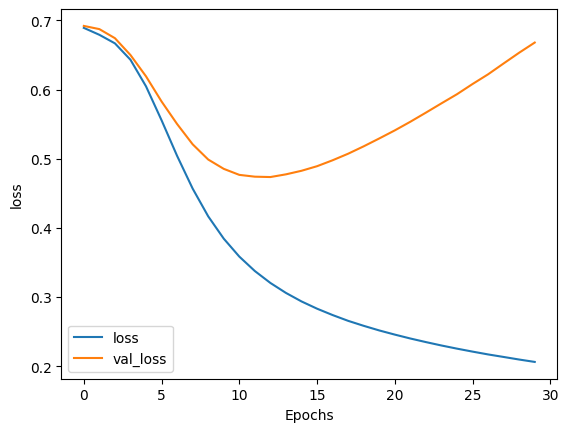

1/1 [==============================] - 0s 89ms/step
I loved this movie
[0.9642924]


that was the worst movie I've ever seen
[0.00319427]


too much violence even for a Bond film
[0.04912308]


a captivating recounting of a cherished myth
[0.84338546]




In [ ]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

## GRU Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirection  (None, 64)                9600      
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73665 (287.75 KB)
Trainable params: 73665 (287.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 25s 33ms/step - loss: 0.6896 - accuracy: 0.5471 - val_loss: 0.6954 - val_accuracy: 0.5092
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - l

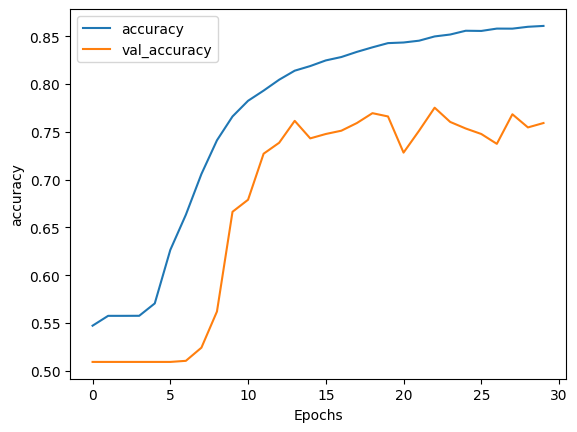

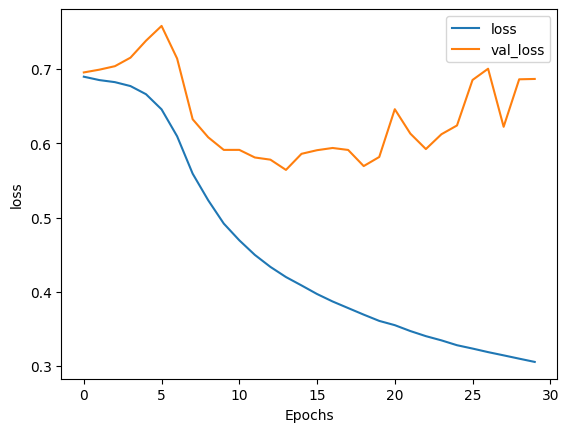

1/1 [==============================] - 1s 553ms/step
I loved this movie
[0.4949179]


that was the worst movie I've ever seen
[0.01819004]


too much violence even for a Bond film
[0.06099879]


a captivating recounting of a cherished myth
[0.56643003]




In [ ]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

# Use multiple bidirectional LSTMs

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 32)            4224      
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74529 (291.13 KB)
Trainable params: 74529 (291.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/6

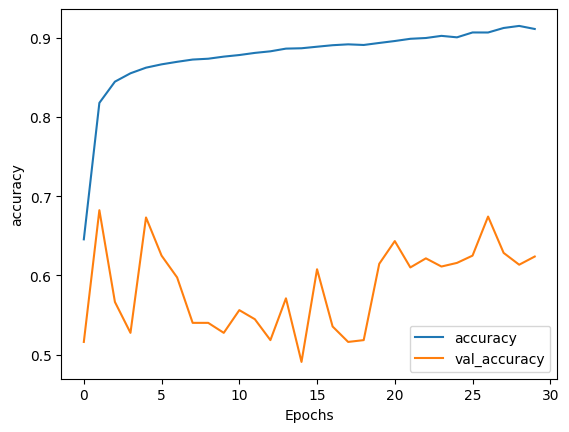

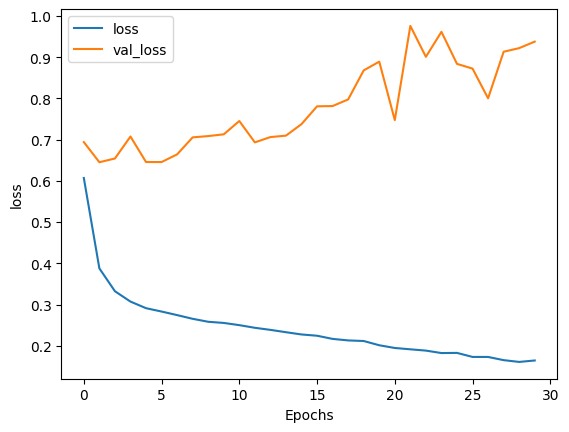

1/1 [==============================] - 2s 2s/step
I loved this movie
[0.6723323]


that was the worst movie I've ever seen
[0.01214666]


too much violence even for a Bond film
[0.00464362]


a captivating recounting of a cherished myth
[0.997858]




In [ ]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

# Try some more reviews

In [ ]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director
 who made my most favorite movie ever, I was very disappointed in the tedious
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7,
               review8, review9, review10]


In [ ]:
print("Embeddings only:\n")
predict_review(model, more_reviews)

Embeddings only:

1/1 [==============================] - 0s 18ms/step
I loved this movie
[0.5901823]


that was the worst movie I've ever seen
[0.01305546]


too much violence even for a Bond film
[0.0115256]


a captivating recounting of a cherished myth
[0.7488748]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.8614057]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.7656798]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.6982485]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.29956567]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed i

In [ ]:
print("With CNN\n")
predict_review(model_cnn, more_reviews)

With CNN

1/1 [==============================] - 0s 46ms/step
I loved this movie
[0.9642924]


that was the worst movie I've ever seen
[0.00319427]


too much violence even for a Bond film
[0.04912308]


a captivating recounting of a cherished myth
[0.84338546]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.96333206]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9699959]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.9420267]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9135669]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the 

In [ ]:
print("With bidirectional GRU\n")
predict_review(model_gru, more_reviews)

With bidirectional GRU

1/1 [==============================] - 0s 18ms/step
I loved this movie
[0.4949179]


that was the worst movie I've ever seen
[0.01819004]


too much violence even for a Bond film
[0.06099879]


a captivating recounting of a cherished myth
[0.56643003]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.6381438]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.3262616]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.10567074]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.0835337]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disapp

In [ ]:
print("With multiple bidirectional LSTM:\n")
predict_review(model_multiple_bidi_lstm, more_reviews)

With multiple bidirectional LSTM:

1/1 [==============================] - 0s 23ms/step
I loved this movie
[0.6723323]


that was the worst movie I've ever seen
[0.01214666]


too much violence even for a Bond film
[0.00464362]


a captivating recounting of a cherished myth
[0.997858]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.9937436]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99838495]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.9994419]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.99557483]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was v